In [2]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import random

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torch
import torch.nn as nn

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

from timeit import default_timer as timer

In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Age, gender clf/age_gender.csv')
data.shape

(23705, 5)

In [150]:
data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32') / 255)

In [151]:
age_list_bins = np.arange(0, 111, 10) 
age_list_bins = np.append(age_list_bins, [116])
age_list_labels = [f"{age_list_bins[i]+1}-{age_list_bins[i+1]}" for i in range(age_list_bins.shape[0]-1)]
age_labels = {i: age_list_labels[i] for i in range(len(age_list_labels))}

ethnicity_labels = {0:'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Hispanic'}

gender_labels = {0: 'Male', 1: 'Female'}

In [152]:
data['age'] = pd.cut(data['age'], age_list_bins, labels=np.arange(len(age_list_bins)-1)).astype('int')

# Distributions

In [153]:
px.histogram(data, x='age', color='gender', category_orders={'age': data['age'].cat.categories})

AttributeError: ignored

In [ ]:
px.histogram(data, x='ethnicity', color='gender')

# Sample images

In [ ]:
rand_list = [random.randint(0, data.shape[0]-1) for i in range(20)]

In [ ]:
plt.figure(figsize=(20, 16))
for i in range(len(rand_list)):
    plt.subplot(4, 5, i+1)
    row = data.iloc[rand_list[i]]
    plt.imshow(row['pixels'].reshape(48, 48), cmap='gray')
    plt.title(f'Age: {row.age}, Ethnicity: {row.ethnicity}, Gender: {row.gender}')
    plt.axis('off')

# Data preparation

In [155]:
train_set, val_set = train_test_split(data, train_size=0.95, random_state=0, stratify=data['age'], shuffle=True)

In [156]:
class MyDataset(Dataset):
    def __init__(self, age_label, ethnicity_label, gender_label, image):
        self.age_label = np.array(age_label)
        self.ethnicity_label = np.array(ethnicity_label)
        self.gender_label = np.array(gender_label)
        self.image = np.array(image)
        
        self.transform = transforms.Compose([
            # transforms.Resize((48, 48)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
        
    def __len__(self):
        return len(self.image)
        
    def __getitem__(self, index):
        age_label = self.age_label[index]
        ethnicity_label = self.ethnicity_label[index]
        gender_label = self.gender_label[index]
        
        image = self.image[index].reshape(48, 48, 1)
        image = self.transform(image)
        
        return image, age_label, ethnicity_label, gender_label
    
train_data = MyDataset(train_set.age, train_set.ethnicity, train_set.gender, train_set.pixels)
val_data = MyDataset(val_set.age, val_set.ethnicity, val_set.gender, val_set.pixels)

In [157]:
batch_size=128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Model

In [158]:
age_features = data['age'].nunique()
ethnicity_features = data['ethnicity'].nunique()
gender_features = data['gender'].nunique()

In [159]:
class MultilabelCNN(nn.Module):
    def __init__(self, age_features, ethnicity_features, gender_features):
        super().__init__()
        
        self.CNNModel = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #24
            # nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #12
            # nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #6
            nn.LeakyReLU(),
            # # nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), #3
            # nn.Dropout(0.1),
            nn.AdaptiveAvgPool2d((1,1)), #flatten
            nn.Flatten()
            # nn.LeakyReLU()
        )

        self.DNNModel = nn.Sequential(
            nn.Linear(256, 128),
            # # nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            # nn.Dropout(0.1),
            nn.LeakyReLU(),
            # nn.Dropout(0.4), 
            nn.Linear(64, 32),
            # nn.Dropout(0.1), 
            nn.LeakyReLU())
        
        self.age_clf = nn.Linear(32, age_features)
        self.ethnicity_clf = nn.Linear(32, ethnicity_features)
        self.gender_clf = nn.Linear(32, gender_features)
        
    def forward(self, x):
        output = self.CNNModel(x).squeeze()
        output = self.DNNModel(output)

        age = self.age_clf(output)
        ethnicity = self.ethnicity_clf(output)
        gender = self.gender_clf(output)
        
        return age, ethnicity, gender

In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultilabelCNN(age_features, ethnicity_features, gender_features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)

def custom_loss(output, target) :
    age_loss = nn.CrossEntropyLoss().to(device)(output[0], target[0])
    ethnicity_loss =  nn.CrossEntropyLoss().to(device)(output[1], target[1])
    gender_loss =  nn.CrossEntropyLoss().to(device)(output[2], target[2])
    
    loss = age_loss + ethnicity_loss + gender_loss
    
    return loss, age_loss.item(), ethnicity_loss.item(), gender_loss.item()

In [161]:
summary(model, input_size=(1, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
MultilabelCNN                            [12]                      --
├─Sequential: 1-1                        [256, 1]                  --
│    └─Conv2d: 2-1                       [32, 48, 48]              320
│    └─MaxPool2d: 2-2                    [32, 24, 24]              --
│    └─LeakyReLU: 2-3                    [32, 24, 24]              --
│    └─Conv2d: 2-4                       [64, 24, 24]              18,496
│    └─MaxPool2d: 2-5                    [64, 12, 12]              --
│    └─LeakyReLU: 2-6                    [64, 12, 12]              --
│    └─Conv2d: 2-7                       [128, 12, 12]             73,856
│    └─MaxPool2d: 2-8                    [128, 6, 6]               --
│    └─LeakyReLU: 2-9                    [128, 6, 6]               --
│    └─LeakyReLU: 2-10                   [128, 6, 6]               --
│    └─Conv2d: 2-11                      [256, 6, 6]               295,168
│

# Train loop

In [162]:
def train_step(model, 
               dataloader,
               loss_function,
               optimizer,
               device):
    
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (image, age, ethnicity, gender) in enumerate(dataloader):        

        image, age, ethnicity, gender = image.to(device), age.to(device), ethnicity.to(device), gender.to(device)

        y_pred = model(image)
        loss = loss_function(y_pred, (age, ethnicity, gender))
        train_loss += loss[0].item()
        
        optimizer.zero_grad()
        
        loss[0].backward()
        
        optimizer.step()
        
        # print(y_pred)

        # y_pred_classes_age = torch.argmax(y_pred[0], dim=1)
        # y_pred_classes_ethnicity = torch.argmax(y_pred[1], dim=1)
        # y_pred_classes_gender = torch.argmax(y_pred[2], dim=1)
        

        correct_prediction = 0
        for i, _ in enumerate(age) :
            if torch.argmax(y_pred[0][i]) == age[i] and \
            torch.argmax(y_pred[1][i]) == ethnicity[i] and \
            torch.argmax(y_pred[2][i]) == gender[i]:
                correct_prediction += 1
                
        train_acc += correct_prediction / image.shape[0]


        # train_acc += (y_pred_classes_age == age and \
        #               y_pred_classes_ethnicity == ethnicity and \
        #               y_pred_classes_gender == gender).sum().item()/len(age)
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

In [163]:
def val_step(model, 
             dataloader,
             loss_function, 
             device):
    
    model.eval()
    val_loss, val_acc = 0, 0
    y_preds = []
    
    with torch.inference_mode():
        for batch, (image, age, ethnicity, gender) in enumerate(dataloader):
            image, age, ethnicity, gender = image.to(device), age.to(device), ethnicity.to(device), gender.to(device)

            y_pred = model(image)

            loss = loss_function(y_pred, (age, ethnicity, gender))
            val_loss += loss[0].item()
            
            # y_pred_classes = torch.argmax(y_pred, dim=2)
            
            # train_acc += (y_pred_classes[0] == age and \
            #               y_pred_classes[1] == ethnicity and \
            #               y_pred_classes[2] == gender).sum().item()/len(age)

            correct_prediction = 0
            for i, _ in enumerate(age) :
                if torch.argmax(y_pred[0][i]) == age[i] and \
                torch.argmax(y_pred[1][i]) == ethnicity[i] and \
                torch.argmax(y_pred[2][i]) == gender[i]:
                    correct_prediction += 1
                
                y_preds.extend([torch.argmax(y_pred[0][i]),
                                torch.argmax(y_pred[1][i]),
                                torch.argmax(y_pred[2][i])])

            val_acc += correct_prediction / image.shape[0]
            
            # y_preds.append(y_pred_classes)
            
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    
    # y_pred_tensor = torch.cat(y_preds)
    return val_loss, val_acc, y_preds

In [164]:
def train(model, 
          train_dataloader,
          val_dataloader,
          loss_function,
          optimizer,
          epochs, 
          device):
    
    results = {'train_loss': [], 
               'train_acc': [], 
               'val_loss': [], 
               'val_acc': []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_function=loss_function,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc, y_preds = val_step(model=model, 
                                              dataloader=val_dataloader,
                                              loss_function=loss_function,
                                              device=device)
        
        print(f'Epoch: {epoch+1} , Train loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}')
        print(f'Train accuracy: {train_acc:.3f}, Validation accuracy: {val_acc:.3f}')
        print()
        
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['train_acc'].append(train_acc)
        results['val_acc'].append(val_acc)
        
    return results, y_preds

# Running model

In [165]:
torch.cuda.manual_seed(0)
torch.manual_seed(0)

epochs = 30

loss_function = custom_loss

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-5)

start_timer = timer()

model_results, preds = train(model=model, 
                             train_dataloader=train_loader,
                             val_dataloader=val_loader,
                             loss_function=loss_function,
                             optimizer=optimizer,
                             epochs=epochs,
                             device=device)

end_timer = timer()

print(f'Total learning time: {(end_timer - start_timer):.3f}')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 , Train loss: 4.099, Validation loss: 3.940
Train accuracy: 0.049, Validation accuracy: 0.070

Epoch: 2 , Train loss: 3.764, Validation loss: 3.630
Train accuracy: 0.089, Validation accuracy: 0.099

Epoch: 3 , Train loss: 3.355, Validation loss: 3.255
Train accuracy: 0.147, Validation accuracy: 0.154

Epoch: 4 , Train loss: 3.022, Validation loss: 2.857
Train accuracy: 0.189, Validation accuracy: 0.207

Epoch: 5 , Train loss: 2.789, Validation loss: 2.671
Train accuracy: 0.223, Validation accuracy: 0.246

Epoch: 6 , Train loss: 2.575, Validation loss: 2.487
Train accuracy: 0.263, Validation accuracy: 0.286

Epoch: 7 , Train loss: 2.409, Validation loss: 2.500
Train accuracy: 0.295, Validation accuracy: 0.270

Epoch: 8 , Train loss: 2.290, Validation loss: 2.257
Train accuracy: 0.314, Validation accuracy: 0.293

Epoch: 9 , Train loss: 2.202, Validation loss: 2.204
Train accuracy: 0.333, Validation accuracy: 0.315

Epoch: 10 , Train loss: 2.117, Validation loss: 2.159
Train accu

# Saving model

In [166]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Age, gender clf/'

torch.save(model.state_dict(), PATH+'model v2.pt')

# Loss & accuracy

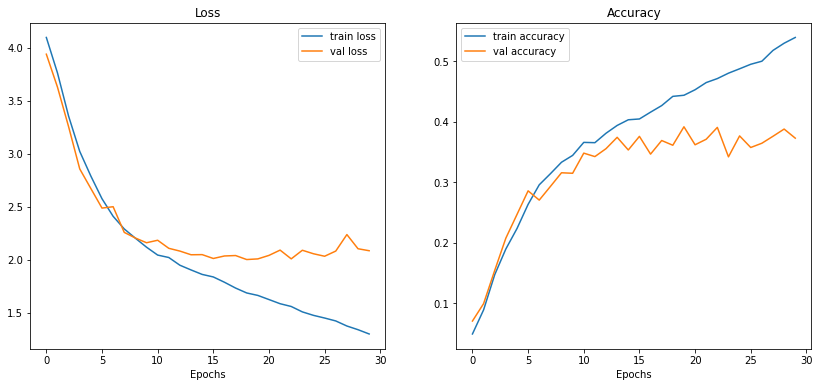

In [167]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(np.arange(len(model_results['train_loss'])), model_results['train_loss'], label='train loss')
plt.plot(np.arange(len(model_results['val_loss'])), model_results['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(len(model_results['train_acc'])), model_results['train_acc'], label='train accuracy')
plt.plot(np.arange(len(model_results['val_acc'])), model_results['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [168]:
age_preds = preds[::3]
ethnicity_preds = preds[1::3]
gender_preds = preds[2::3]

age_preds_np = np.array(list(map(lambda x: x.cpu().item(), age_preds)))
ethnicity_preds_np = np.array(list(map(lambda x: x.cpu().item(), ethnicity_preds)))
gender_preds_np = np.array(list(map(lambda x: x.cpu().item(), gender_preds)))

In [169]:
from mlxtend.plotting import plot_confusion_matrix

In [170]:
def plot_cms(val_data_label, preds_np, class_labels):
  cm = confusion_matrix(val_data_label, preds_np)

  n = np.unique(val_data_label).shape[0]
  ticks = np.arange(n)
  labels = list(class_labels.values())
  plot_confusion_matrix(cm, figsize=(n//2, n//2))
  plt.xticks(ticks=ticks, labels=labels, rotation=45)
  plt.yticks(ticks=ticks, labels=labels)
  plt.show();

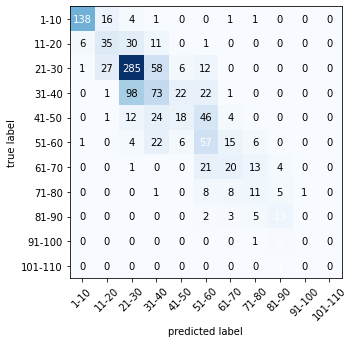

In [171]:
plot_cms(val_data.age_label, age_preds_np, age_labels)

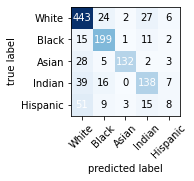

In [172]:
plot_cms(val_data.ethnicity_label, ethnicity_preds_np, ethnicity_labels)

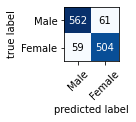

In [173]:
plot_cms(val_data.gender_label, gender_preds_np, gender_labels)

In [174]:
from PIL import Image

In [175]:
def predict_aeg(path, model):
  face = Image.open(path)

  transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((48, 48)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
  
  transformed_face = transform(face)

  pred_age, pred_ethnicity, pred_gender = model(transformed_face.to(device))

  pred_age = torch.argmax(pred_age).item()
  pred_ethnicity = torch.argmax(pred_ethnicity).item()
  pred_gender = torch.argmax(pred_gender).item()

  print(f'Age: {age_labels[pred_age]}\nEthnicity: {ethnicity_labels[pred_ethnicity]}\nGender: {gender_labels[pred_gender]}')
  print()
  display(transforms.Resize((400, 300))(face))

Age: 21-30
Ethnicity: White
Gender: Female



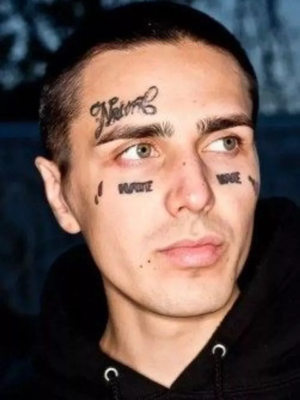

In [176]:
predict_aeg('face.jpg', model)